# Loading Files and Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
import io
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
import seaborn as sns

myCars = pd.read_csv("/content/drive/MyDrive//cleanFeatures.csv", low_memory=False)

#Custom Functions

In [ ]:
# Super usefull found on stack overflow https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

#this function makes it easier to toggle our categorical data between one hot encoding and ordinal encoding to see which is more effective.
def catergorical_handler (original_dataframe, feature_to_encode, choice):
  if (choice == 1):
    return encode_and_bind(original_dataframe, feature_to_encode)
  if (choice == 2):
    enc = OrdinalEncoder()
    original_dataframe[[feature_to_encode]] = enc.fit_transform(original_dataframe[[feature_to_encode]])
    return original_dataframe

#takes an x, y, fits and scores regression
def score (x,y):    
    reg = LinearRegression().fit(x, y)
    print(reg.score(x, y))
    print(mean_squared_error(y, reg.predict(x), squared=False))

#evaluation environment - reg is already fit, give an X and y to predict/score
def eval(reg, X, y):
  prediction = reg.predict(X)
  y = y
  print("R2 score: "+str(reg.score(X,y)))
  print("Mean Squared Error: "+ str(mean_squared_error(y, reg.predict(X),squared=False)))

#splits data according to different proportions of test/train
def splits(x,s,t):
  x_trainExt, x_test, y_trainExt, y_test = train_test_split(x, msrp, train_size=.8 ,test_size=.2, random_state=12)
  x_train, x_val, y_train, y_val = train_test_split(x_trainExt, y_trainExt, train_size= s,test_size=t, random_state=8)
  print("Splits: test="+str(.2)+" train="+str(.8*s)+" val="+str(.8*t))
  return x_test,y_test,x_train,y_train,x_val, y_val

#exploratory column checker
def columnChecker(x,y):
  print(x.describe())
  sns.scatterplot(x=x ,y=y)
  plt.show()
  sns.histplot(x)

#finds the mean of the values that are not negative, and replaces the -1(formaly nans). Used in previous version of notebook, liked it so much we kept it around.
def killallnans(colName):
  mask = myCars[colName] > 0
  meanRW = myCars[mask][colName].mean()

  mask = myCars[colName] < 0
  indexes = myCars[mask].index

#takes two sets of data makes a regression model from them and evalutes the residual's.
#Uses different models based on "type" value passed to it,  1 means RidgeCV, 2 means Linear Regression
def residualEval(x,y,type ):
  if type is 1:
    reg = RidgeCV().fit(x,y)
    sns.set(rc = {'figure.figsize':(8,8)})
    sns.histplot(x=y - reg.predict(x))
    plt.show()

    sns.scatterplot( x=y, y=y - reg.predict(x),alpha=.4,linewidth=0)
    plt.show()
  else:
    reg = LinearRegression().fit(x, y)
    sns.set(rc = {'figure.figsize':(8,8)})
    sns.histplot(x=y - reg.predict(x))
    plt.show()

    sns.scatterplot( x=y, y=y - reg.predict(x),alpha=.4,linewidth=0)
    plt.show()

In [ ]:
#1 is one-hot-encoding, 2 is ordinal encoding
original = myCars
categorical = ["Model","Make","Vehicle Type","Spare Wheel Material","Engine Type","Suspension Type - Rear","Suspension Type - Front","Transfer Case Model","Brake Type","Drivetrain","Steering Type","Wheel Material","EPA Classification","Suspension Type - Rear (Cont.)","Suspension Type - Front (Cont.)","Trans Description Cont.","Axle Type - Front","Axle Type - Rear",]
def encode(myCars, x):
  for cats in categorical:
    myCars = catergorical_handler(myCars,cats,x)
  return myCars


# DataFrames & Data Sets 

This cell contains all the transformations we did on our data set in the proccess of data exploration, and the ones that we used multiple times for model testing.

In [ ]:
#encodes categorical columns, separates features from target, and scales feature data
myCars = encode(myCars,2)
drop = myCars.drop(columns=["Starting MSRP", "Trim"])
msrp = myCars["Starting MSRP"] 

#standard scales all of the x data 
scaler = StandardScaler()
scaled=scaler.fit_transform(drop)
#makes data splits of scaled x data
x_testScaled,y_testScaled,x_trainScaled,y_trainScaled,x_valScaled, y_valScaled=splits(scaled,.8,.2)
#puts split data back into Data Frames
xtrain = pd.DataFrame(x_trainScaled)
xval = pd.DataFrame(x_valScaled)

#scaled data frame with accurate column names
numberCat = pd.DataFrame()

for cats in range(0,len(drop.columns)-1):
  numberCat[drop.columns[cats]] = scaled.transpose(1,0)[cats]

#slice of the dataframe without the ordinal encoded and one hote encoded columns.
trimmed = numberCat.drop(columns = categorical)
for cats in trimmed:
  count = len(trimmed[cats].value_counts())
  if(count < 3):
    trimmed = trimmed.drop(columns = cats)


Splits: test=0.2 train=0.6400000000000001 val=0.16000000000000003


We had a lot of data, and where not sure how much was usefull, and how much was noise. To contrast with our potentialy noisy data set, we made a slimmer data set comprised only of columns with a higher correlation than 25% or lower then -25% with msrp.
This cell contains the creation of that data set, & and any transformations that where repeatadly use in the proccess of model testing.

In [ ]:
#used to find baseline - made two-var linear regressions with every column and found the top scoring categories
gCorr = []
for column in xtrain.columns:
    reg = LinearRegression().fit(xtrain[[column]], y_trainScaled)
    x = reg.score(xtrain[[column]], y_trainScaled)
    y = mean_squared_error(y_trainScaled, reg.predict(xtrain[[column]]), squared=False)
    if (drop[drop.columns[column]].corr(msrp) > .25):
      gCorr.append(column)
    if (drop[drop.columns[column]].corr(msrp) < -.25):
      gCorr.append(column)

slimDrop = pd.DataFrame()
#made a copy of the data that only kept columns with more then 25% both positively and negatively
for index in gCorr:
  slimDrop[drop.columns[index]] = drop[drop.columns[index]]
#standard Scaled slim data 
scaler = StandardScaler()
scaled2=scaler.fit_transform(slimDrop)
 #made splits of slim data
x_testSlim,y_testSlim,x_trainSlim,y_trainSlim,x_valSlim, y_valSlim=splits(scaled2,.8,.2)


Splits: test=0.2 train=0.6400000000000001 val=0.16000000000000003


# Exploratory Analysis

Decided to look at msrp to get an idea of what that data looks like. As can be seen below average msrp is $50097.40

count      2427.000000
mean      50097.409147
std       31029.301046
min       13600.000000
25%       33397.500000
50%       42495.000000
75%       54745.000000
max      334700.000000
Name: Starting MSRP, dtype: float64


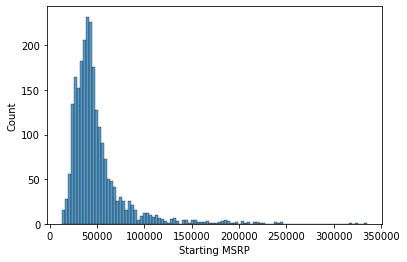

In [ ]:
print(myCars["Starting MSRP"].describe())
sns.histplot(myCars["Starting MSRP"])

Horsepower having a high correlation makes sense to me, but I'm surprised how high all these tire columns correlate with msrp. Also a lot of these high correlation columns seem to be luxury features, you'd see in deluxe trims, or luxury vehicles. Explored the possible benefits of both creating a model with all of our data columns, or with using a slimmer data set more highly correlated with the column our model is trying to predict. Would be unrealistic to go explore all of the data column in our full data set but it we did try our best to check and clean all of them in our cleaning notebook. Considering This slim model has only 40 columns, and even less numerical columns, we went ahead and did some exploratory analysis on all of them.


In [ ]:
for index in gCorr:
  reg = LinearRegression().fit(xtrain[[index]], y_trainScaled)
  print(drop.columns[index]+" Correlation "+str(drop[drop.columns[index]].corr(msrp)))
  eval(reg, xtrain[[index]], y_trainScaled)
  print()
#moved up
#slimDrop = pd.DataFrame()
#
#for index in gCorr:
#  slimDrop[drop.columns[index]] = drop[drop.columns[index]]

Spare Wheel Material Correlation -0.3116468712768646
R2 score: 0.10275730580205455
Mean Squared Error: 30969.84790249172

Trans Description Cont. Correlation -0.25804635637183737
R2 score: 0.062709170286944
Mean Squared Error: 31653.46743063034

Suspension Type - Front Correlation -0.3817954220217589
R2 score: 0.14607117893865706
Mean Squared Error: 30213.075987067834

Front Hip Room Correlation 0.26223537973503014
R2 score: 0.06250630356750875
Mean Squared Error: 31656.892774967157

Suspension Type - Front (Cont.) Correlation -0.25554609569969383
R2 score: 0.06088796135400143
Mean Squared Error: 31684.204742820973

Rear Wheel Diameter (in) Correlation 0.5889846167807309
R2 score: 0.35629936986546584
Mean Squared Error: 26231.67809651656

Rear Wheel Width (in) Correlation 0.7186117469077673
R2 score: 0.51359625648866
Mean Squared Error: 22802.505096164776

Front Wheel Diameter (in) Correlation 0.5738445226262648
R2 score: 0.3395093659828441
Mean Squared Error: 26571.583650001197

Front

The cells below contain,  a barplot and a boxplot of all of the columns in a scaled version of our data. They can be enlarged by clicking on the graph.

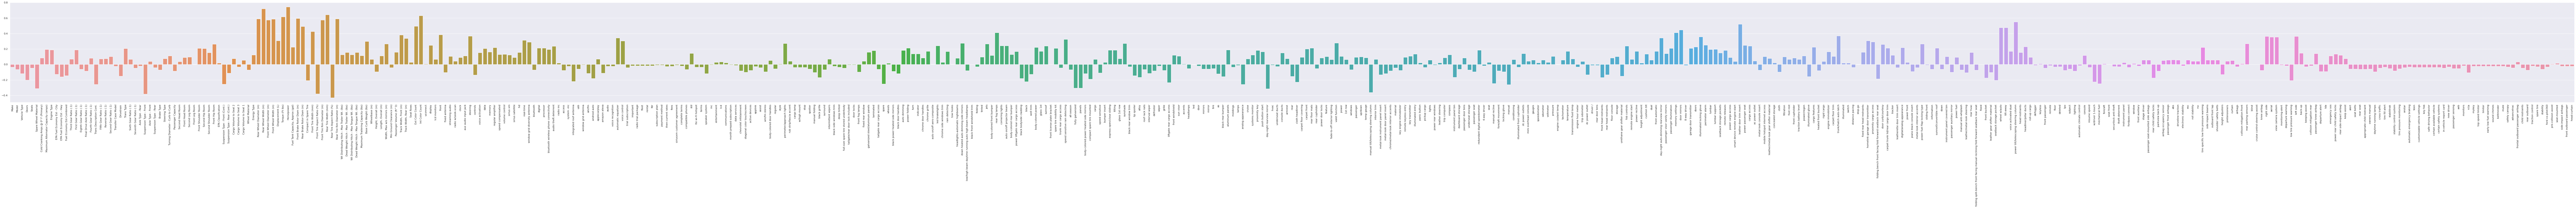

In [ ]:
sns.set(rc = {'figure.figsize':(200,8)})
ax=sns.barplot(x=drop.columns, y=[myCars[x].corr(msrp) for x in drop.columns],orient="v")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);

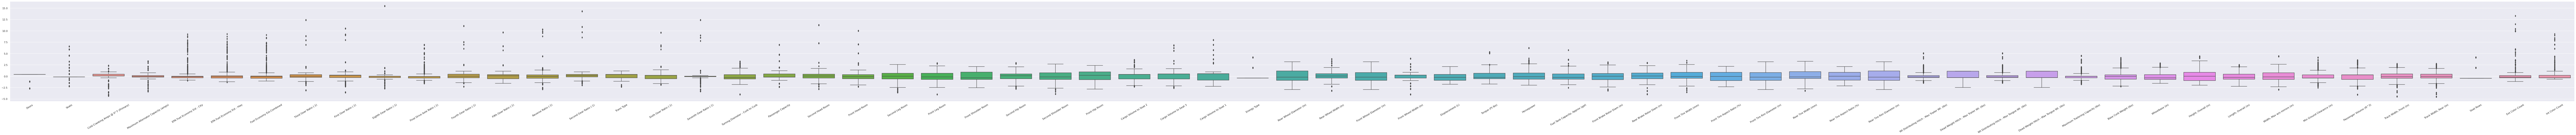

In [ ]:
ax=sns.boxplot(data = trimmed)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

In [ ]:
#filtered out the number columns from the categorical columns in slimDrop to make it easier to do some data examination on them.
numberDog = slimDrop
for cats in categorical:
  for dogs in range (0,len(numberDog.columns)-1):
    if(numberDog.columns[dogs] == cats):
     numberDog = numberDog.drop(columns=cats)
for cats in numberDog.columns:
  counter = numberDog[cats].value_counts()
  if (len(counter) < 3 ):
    v = numberDog.drop(columns=cats)
numberDog.columns

Index(['Front Hip Room', 'Rear Wheel Diameter (in)', 'Rear Wheel Width (in)',
       'Front Wheel Diameter (in)', 'Front Wheel Width (in)',
       'Displacement (L)', 'Torque (Ft lbs)', 'Horsepower',
       'Front Brake Rotor Diam (in)', 'Rear Brake Rotor Diam (in)',
       'Front Tire Width (mm)', 'Front Tire Aspect Ratio (%)',
       'Front Tire Rim Diameter (in)', 'Rear Tire Width (mm)',
       'Rear Tire Aspect Ratio (%)', 'Rear Tire Rim Diameter (in)',
       'Base Curb Weight (lbs)', 'Width, Max w/o mirrors (in)',
       'Track Width, Front (in)', 'Track Width, Rear (in)', 'Ext Color Count',
       'Int Color Count', 'front', 'steering', 'real-time',
       'window grid diversity antenna', 'automatic equalizer', 'voice control',
       'perimeter/approach lights', 'spare',
       'down heated auto dimming side mirrors', 'jets', 'rear fog lamps',
       'speed sensitive rain detecting', 'fully galvanized', 'panels',
       'sunshade', 'analog appearance', 'day-night rearview mirro

As we can see from the graph below, there are some cars that are "outliers" for torque values > 1000. The black dots (from the color coated graph below) represent electric vehicles, mostly Teslas of varying models. The light pink dots represent gas powered vehicles, more specifically, turbo diesels pick-ups (models are Ford f-250's, f-350's, and f-450's). Very interesting, I would have thought it would all be electric cars, but it seems that there is still some powerful I.C. vehicles.

count    2427.000000
mean      317.334707
std       138.920915
min        74.000000
25%       240.000000
50%       280.000000
75%       410.000000
max      1050.000000
Name: Torque (Ft lbs), dtype: float64


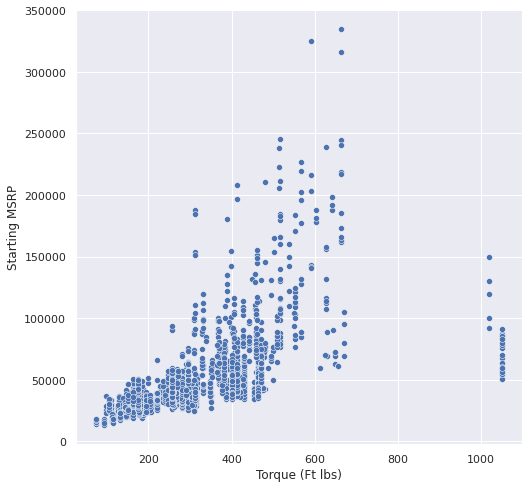

Text(0, 0.5, 'Starting MSRP')

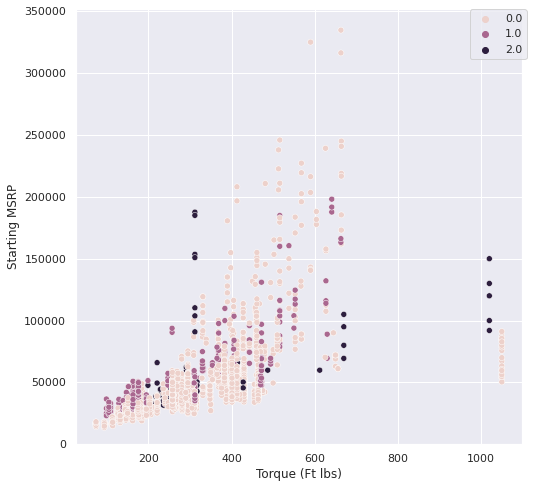

In [ ]:
sns.set(rc = {'figure.figsize':(8,8)})
columnChecker(myCars["Torque (Ft lbs)"] ,myCars["Starting MSRP"])
sns.scatterplot(x=myCars["Torque (Ft lbs)"] ,y=myCars["Starting MSRP"], hue = original["Energy Type"])
plt.legend(bbox_to_anchor=(1.01,1), borderaxespad=0)
plt.ylabel("Starting MSRP")

Some more outliers for vehicles that have > 1000 hp. Interestingly enough, these cars are also Tesla models. Overall, they are a great "bang for buck" value when considering their high torque and horsepower values for a fraction of the price compared to other models.

count    2427.00000
mean      305.34281
std       115.44929
min        78.00000
25%       227.00000
50%       291.00000
75%       385.00000
max      1020.00000
Name: Horsepower, dtype: float64


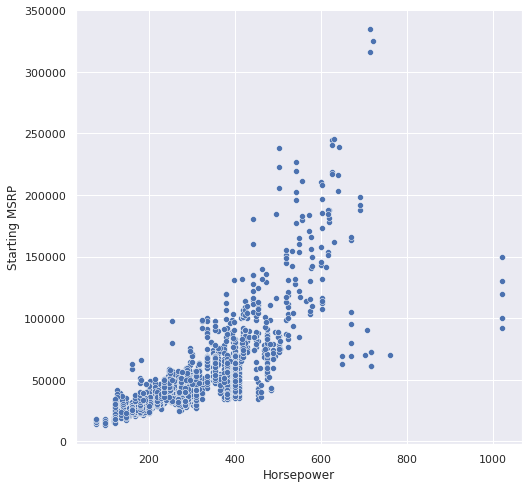

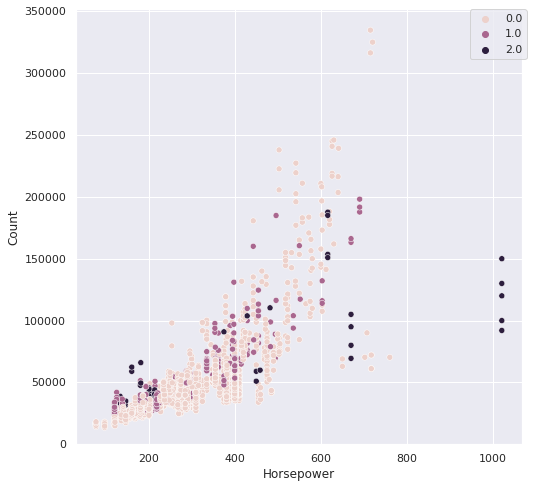

In [ ]:
columnChecker(myCars["Horsepower"] ,myCars["Starting MSRP"])

sns.scatterplot(x= myCars["Horsepower"] , y=myCars["Starting MSRP"], hue = myCars["Energy Type"])

plt.legend(bbox_to_anchor=(1.01,1), borderaxespad=0)

Below is our Ext Color Count, which simply shows the amount of exterior colors each model has. As you can see, most cars will have less than 20 colors. In fact, when calculating how many of our cars had less than 20 colors, it was almost 96%. It seems that there is a small cluster of cars with over 80 colors. It seems that if you want that many variation of colors, you're going to be paying a minimum of 150k.

count    2427.000000
mean        9.788216
std         7.603291
min         1.000000
25%         7.000000
50%         8.000000
75%        11.000000
max       111.000000
Name: Ext Color Count, dtype: float64


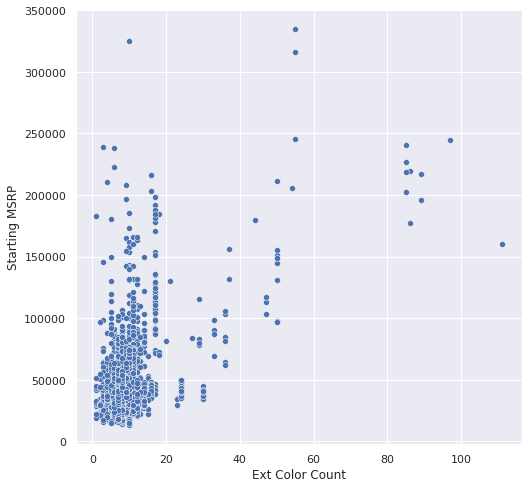

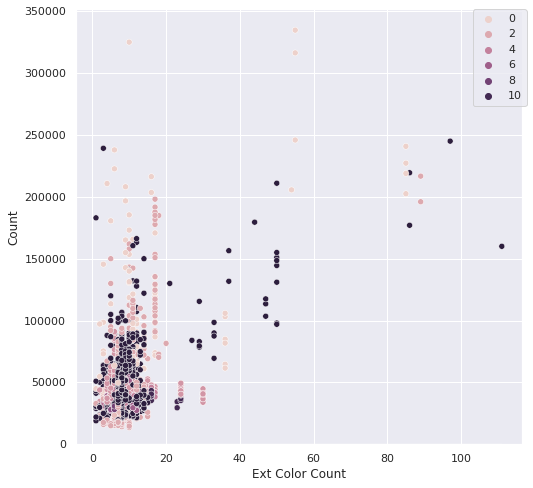

In [ ]:
columnChecker(myCars["Ext Color Count"],myCars["Starting MSRP"])

sns.scatterplot(x = myCars["Ext Color Count"], y = myCars["Starting MSRP"], hue = myCars["Vehicle Type"])
plt.legend(bbox_to_anchor=(1.01,1), borderaxespad=0)

In [ ]:
#simply showing the percentages. If you want tosee the data frame for cars less than 21 colors, just simply type in 'pull'
mask = myCars["Ext Color Count"] < 21
pull = myCars[mask]

percent = len(pull) / len(myCars["Ext Color Count"])

percent

0.9571487433044912

Not too much to go on below for interior colors. Most of our cars have less than 20 interior colors. The ones with more than 20 colors are high-end luxury or sports cars. If one wants a car with more than 20 colors, you will have to pay a minimum of 100k. One thing I found interesting was finding that most cars (roughly 90%) have less than 5 interior colors to choose from.

count    2427.000000
mean        3.277297
std         3.410037
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        35.000000
Name: Int Color Count, dtype: float64


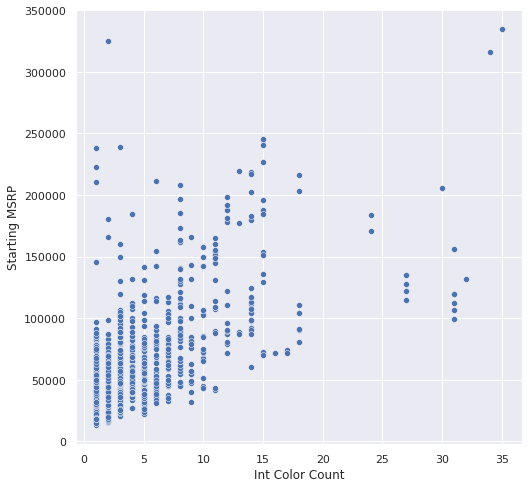

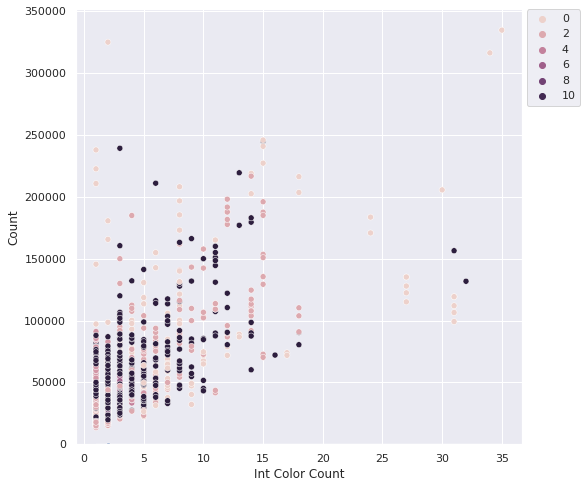

In [ ]:
columnChecker(myCars["Int Color Count"],myCars["Starting MSRP"])
sns.scatterplot(x = myCars["Int Color Count"], y = myCars["Starting MSRP"], hue = myCars["Vehicle Type"])
plt.legend(bbox_to_anchor=(1.01,1), borderaxespad=0)

In [ ]:
#Simply showing the percentages for cars with certain amounts of colors. Delete or ignore if needed.
#More than 20 interior features
mask = myCars["Int Color Count"] > 20
pull = myCars[mask]

percent = len(pull) / len(myCars["Int Color Count"])


#5 interior features or less
mask = myCars["Int Color Count"] < 6
pull = myCars[mask]

percent2 = len(pull) / len(myCars["Int Color Count"])

count    2427.000000
mean       18.332715
std         1.480024
min        14.000000
25%        17.000000
50%        18.000000
75%        20.000000
max        23.000000
Name: Rear Wheel Diameter (in), dtype: float64


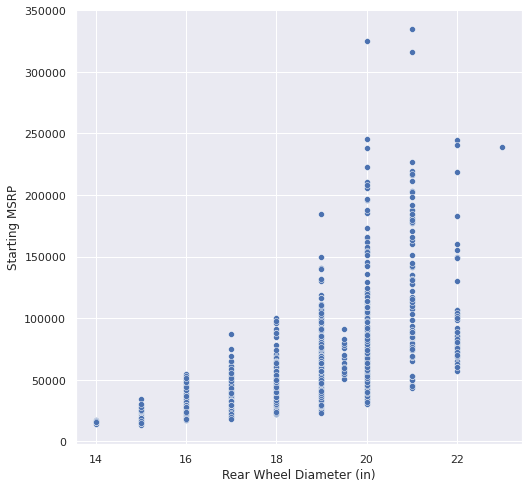

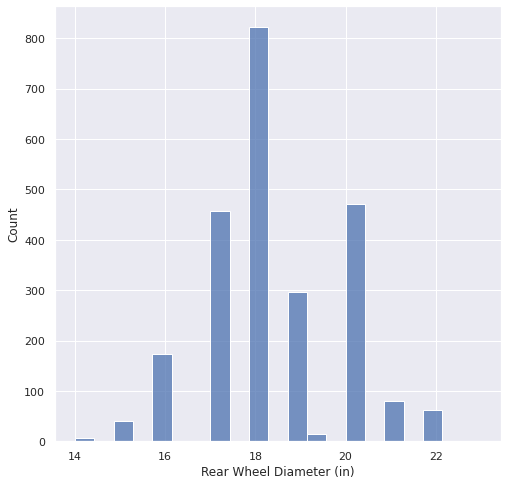

In [ ]:
columnChecker(myCars["Rear Wheel Diameter (in)"],myCars["Starting MSRP"])

count    2427.000000
mean        7.936665
std         1.077381
min         4.500000
25%         7.500000
50%         8.000000
75%         8.500000
max        12.000000
Name: Rear Wheel Width (in), dtype: float64


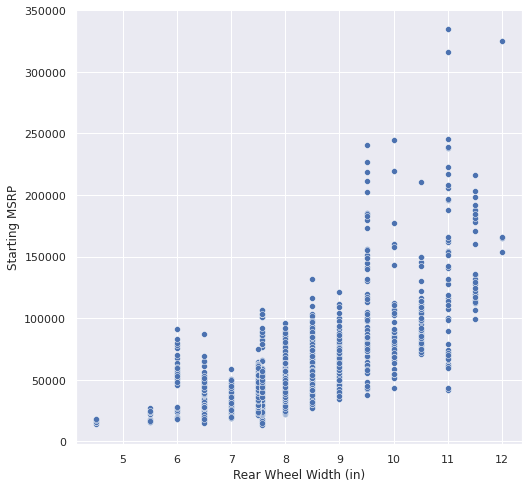

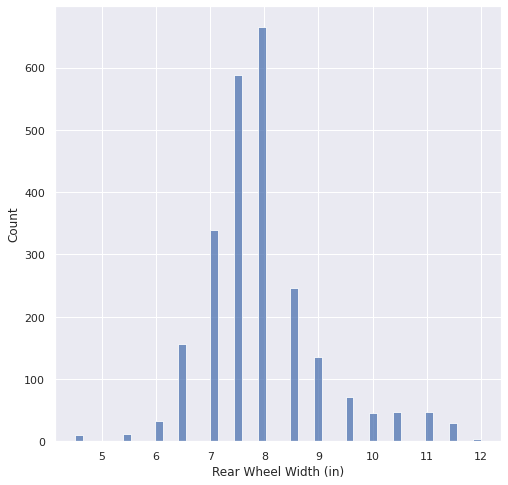

In [ ]:
columnChecker(myCars["Rear Wheel Width (in)"],myCars["Starting MSRP"])

count    2427.000000
mean       18.321178
std         1.468323
min        14.000000
25%        17.000000
50%        18.000000
75%        19.500000
max        23.000000
Name: Front Wheel Diameter (in), dtype: float64


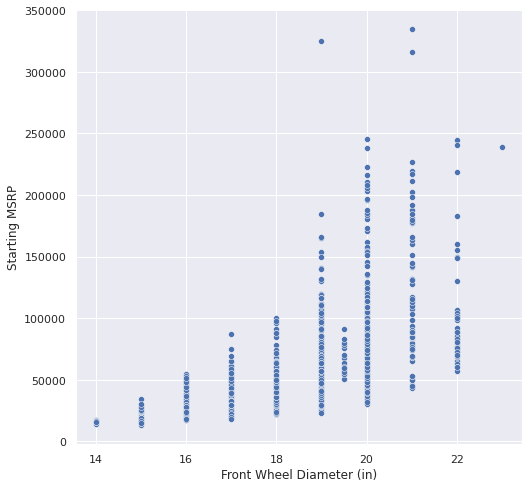

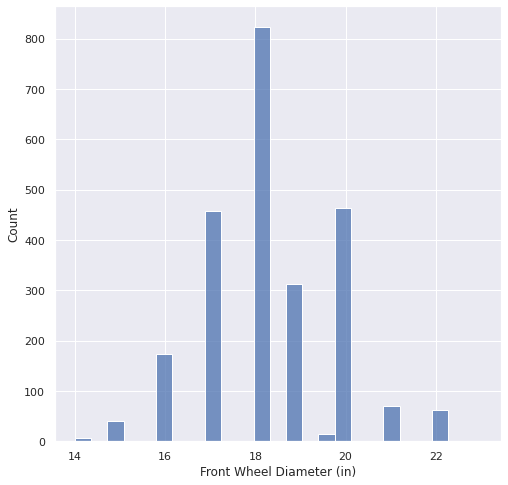

In [ ]:
columnChecker(myCars["Front Wheel Diameter (in)"],myCars["Starting MSRP"])

count    2427.000000
mean      245.922950
std        23.153424
min       165.000000
25%       235.000000
50%       245.000000
75%       265.000000
max       325.000000
Name: Front Tire Width (mm), dtype: float64


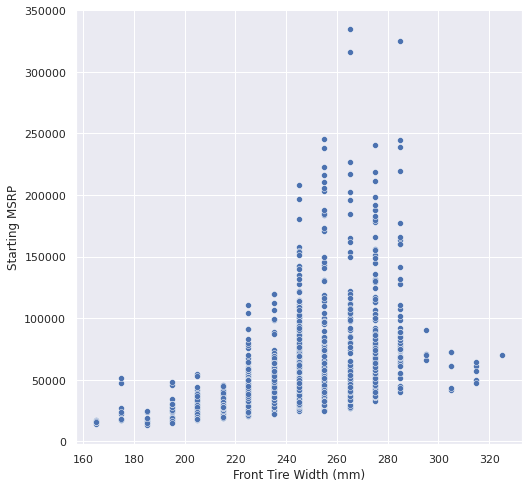

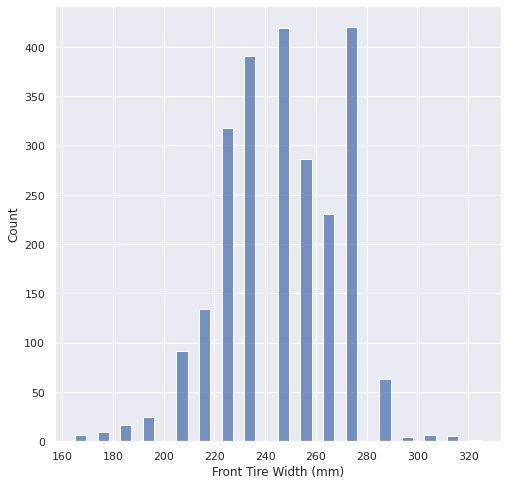

In [ ]:
columnChecker(myCars["Front Tire Width (mm)"],myCars["Starting MSRP"])

count    2427.000000
mean       18.323651
std         1.468622
min        14.000000
25%        17.000000
50%        18.000000
75%        19.500000
max        23.000000
Name: Front Tire Rim Diameter (in), dtype: float64


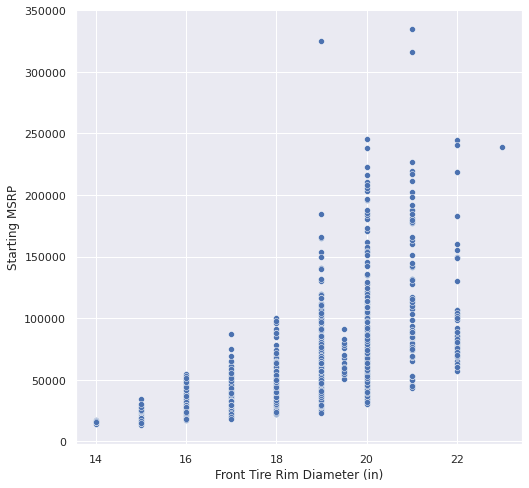

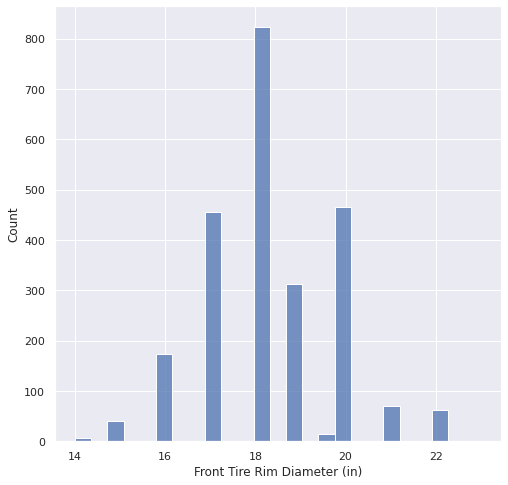

In [ ]:
columnChecker(myCars["Front Tire Rim Diameter (in)"],myCars["Starting MSRP"])

count    2427.000000
mean      249.305727
std        26.345923
min       165.000000
25%       235.000000
50%       245.000000
75%       275.000000
max       335.000000
Name: Rear Tire Width (mm), dtype: float64


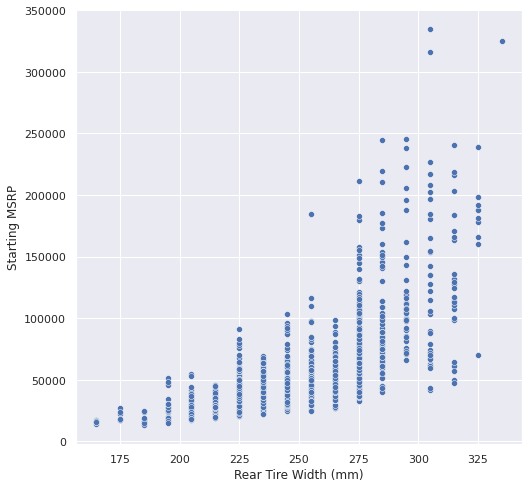

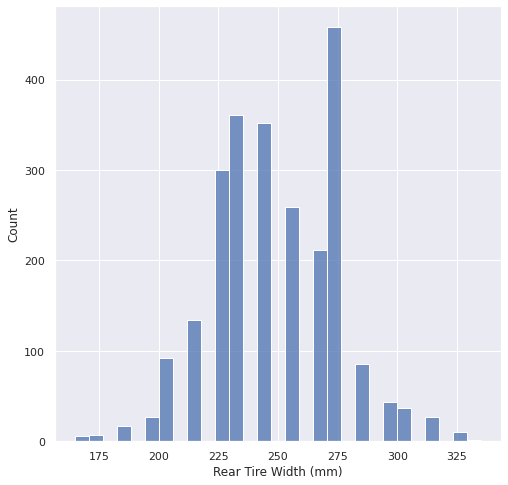

In [ ]:
columnChecker(myCars["Rear Tire Width (mm)"],myCars["Starting MSRP"])

count    2427.000000
mean       18.333951
std         1.480442
min        14.000000
25%        17.000000
50%        18.000000
75%        20.000000
max        23.000000
Name: Rear Tire Rim Diameter (in), dtype: float64


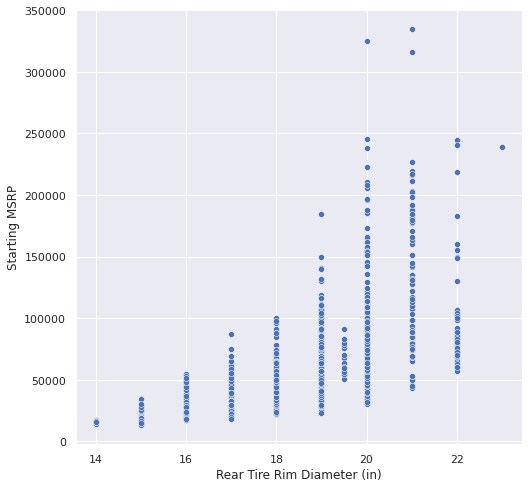

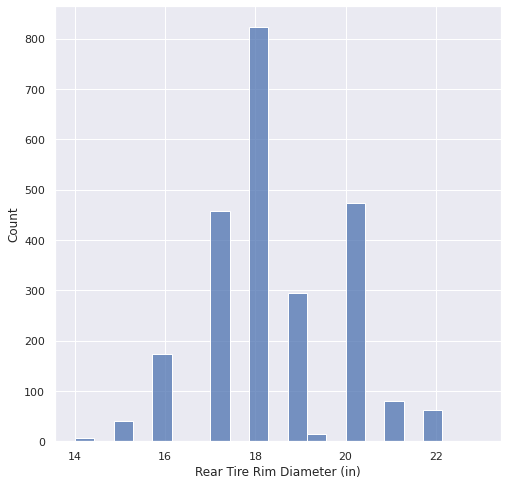

In [ ]:
columnChecker(myCars["Rear Tire Rim Diameter (in)"],myCars["Starting MSRP"])


### Reasoning for straight lines in some of our graphs below.
Some of our columns below have a many values stacked in a straight vertical line along a certain value of x. The reason for this is because we changed all of our nan's replacing them with the mean of their column by vehicle type, thus all those changed nan values are changed to the specific value of x.

This is an example to see outliers and to view which vehicle type those outliers belong to,Otherwise there is not much to see. Most cars seem to fall within a certain threshold of head room and span from many different vehicle types. The only thing we can say indefintely in this instance, is that those who are looking for great headspace room for their passengers, 'full-size passenger vans' are great!

count    2427.000000
mean       38.792354
std         2.344273
min        32.100000
25%        37.800000
50%        38.900000
75%        39.800000
max        65.200000
Name: Second Head Room, dtype: float64


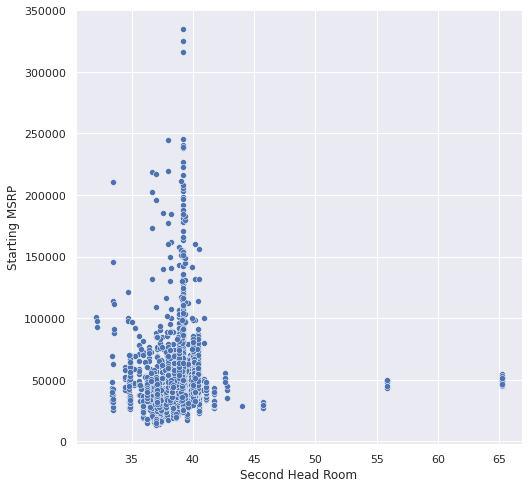

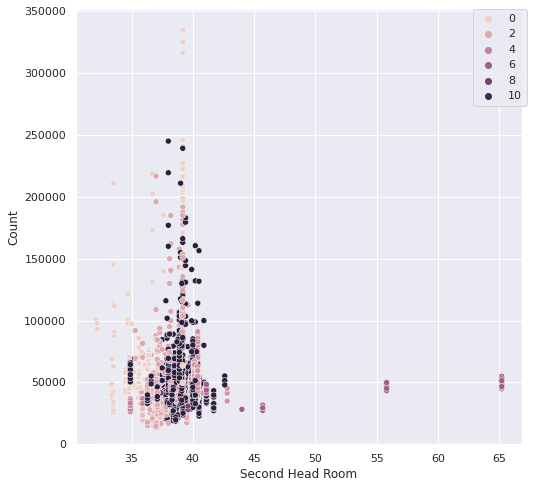

In [ ]:
columnChecker(myCars['Second Head Room'],myCars["Starting MSRP"])

sns.scatterplot(x = myCars['Second Head Room'], y=myCars["Starting MSRP"], hue= myCars['Vehicle Type'])
plt.legend(bbox_to_anchor=(1.01,1), borderaxespad=0)


In [ ]:
#Added this just see the outlier vehicle type(s)

mask = myCars["Second Head Room"] > 55

pull = myCars[mask]

pull[["Second Head Room" , "Vehicle Type"]]

Second Head Room  Vehicle Type
2192              55.8           6.0
2194              55.8           6.0
2195              65.2           6.0
2197              55.8           6.0
2198              55.8           6.0
2200              55.8           6.0
2201              65.2           6.0
2202              65.2           6.0
2203              55.8           6.0
2205              65.2           6.0
2206              65.2           6.0
2207              55.8           6.0
2208              65.2           6.0
2209              65.2           6.0
2210              55.8           6.0
2213              65.2           6.0

count    2427.000000
mean       40.170476
std         2.338039
min        34.800000
25%        38.850000
50%        39.900000
75%        41.000000
max        63.600000
Name: Front Head Room, dtype: float64


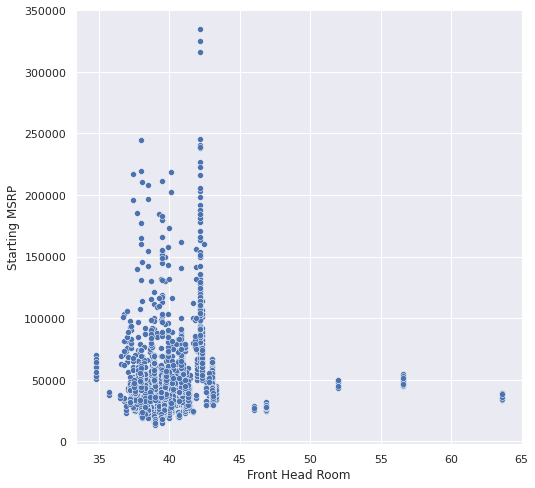

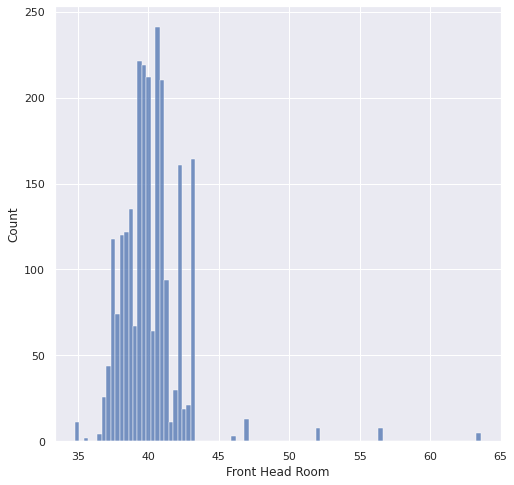

In [ ]:
columnChecker(myCars['Front Head Room'],myCars["Starting MSRP"])


count    2427.000000
mean       37.501240
std         3.607013
min        24.600000
25%        35.240000
50%        37.400000
75%        39.900000
max        46.800000
Name: Second Leg Room, dtype: float64


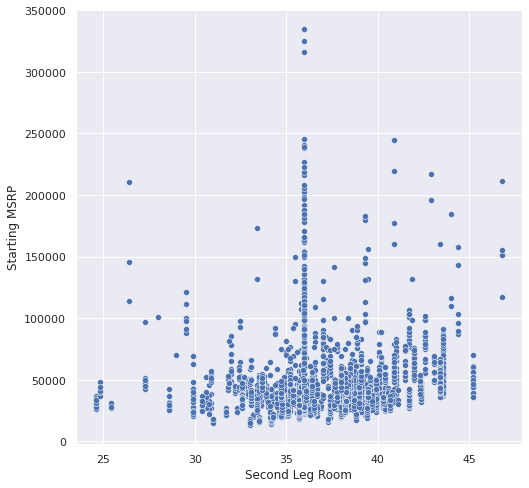

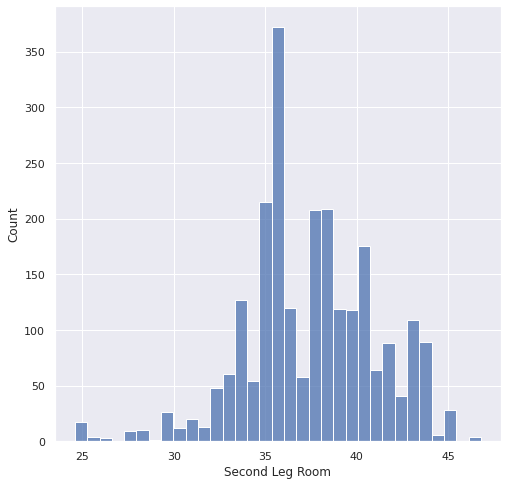

In [ ]:
columnChecker(myCars['Second Leg Room'],myCars["Starting MSRP"])


count    2427.000000
mean       42.226840
std         1.411276
min        36.600000
25%        41.200000
50%        42.000000
75%        43.100000
max        46.300000
Name: Front Leg Room, dtype: float64


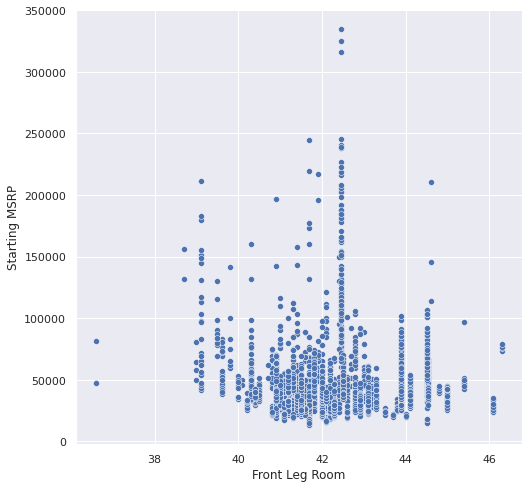

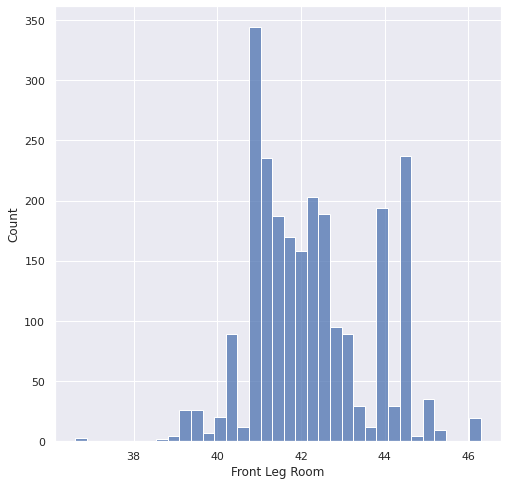

In [ ]:
columnChecker(myCars['Front Leg Room'],myCars["Starting MSRP"])


count    2427.000000
mean       59.900146
std         4.289130
min        49.000000
25%        56.700000
50%        58.300000
75%        63.800000
max        68.850000
Name: Front Shoulder Room, dtype: float64


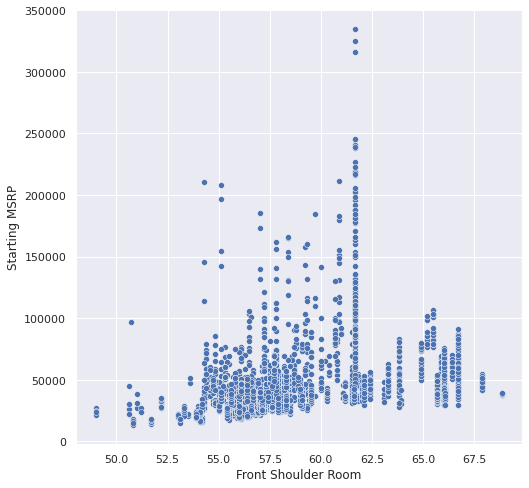

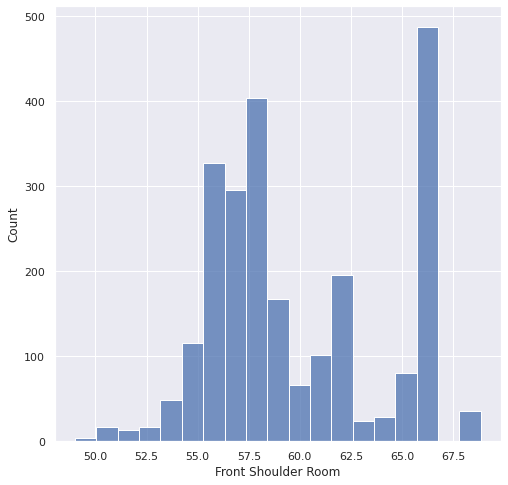

In [ ]:
columnChecker(myCars['Front Shoulder Room'],myCars["Starting MSRP"])


count    2427.000000
mean       56.366495
std         4.822504
min        42.900000
25%        53.500000
50%        56.795890
75%        58.700000
max        70.400000
Name: Second Hip Room, dtype: float64


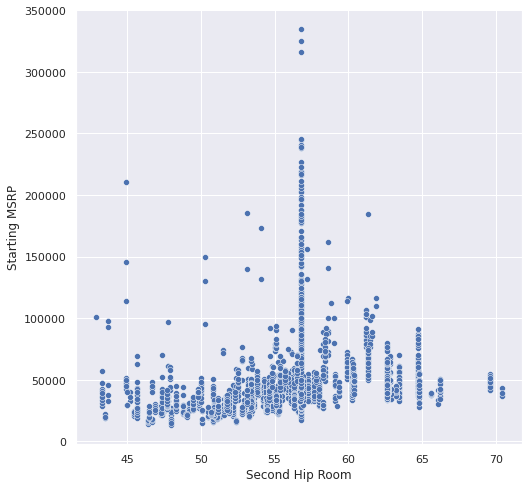

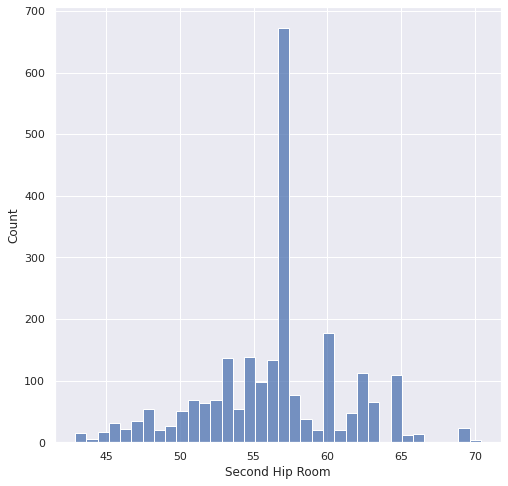

In [ ]:
columnChecker(myCars['Second Hip Room'],myCars["Starting MSRP"])


count    2427.000000
mean       58.580121
std         4.834719
min        39.700000
25%        55.200000
50%        57.800000
75%        62.100000
max        71.400000
Name: Second Shoulder Room, dtype: float64


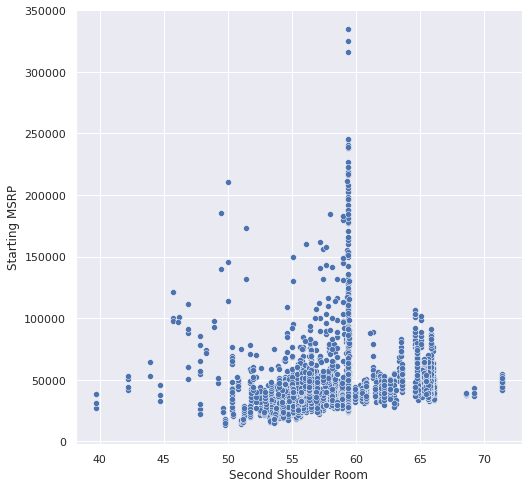

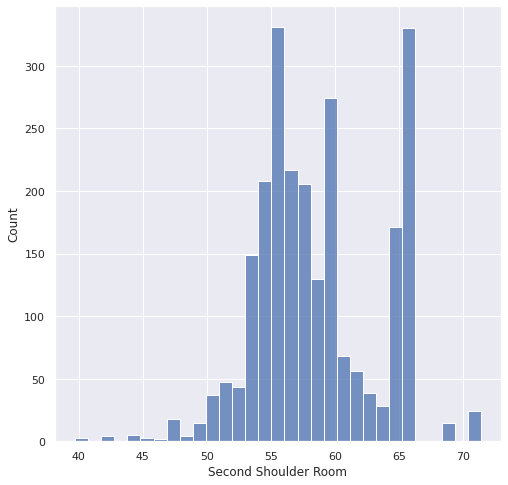

In [ ]:
columnChecker(myCars['Second Shoulder Room'],myCars["Starting MSRP"])


count    2427.000000
mean       57.625337
std         3.298967
min        48.200000
25%        55.100000
50%        58.215718
75%        60.700000
max        65.480000
Name: Front Hip Room, dtype: float64


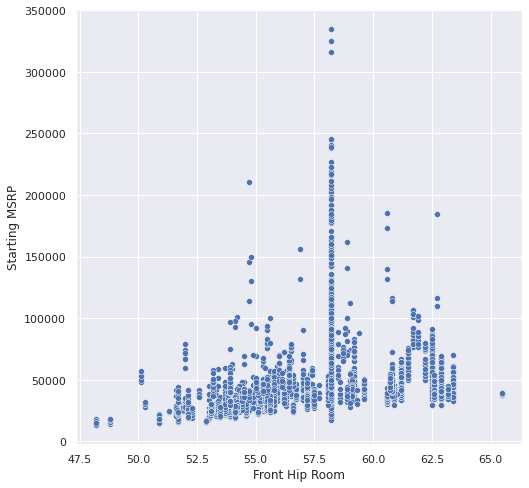

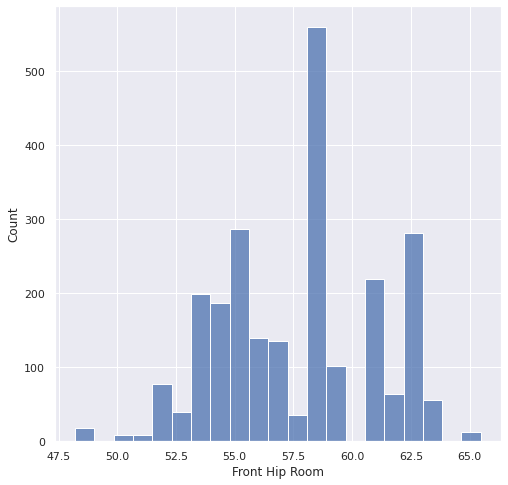

In [ ]:
columnChecker(myCars['Front Hip Room'],myCars["Starting MSRP"])


count    2427.000000
mean       55.793160
std        11.084033
min        30.000000
25%        45.000000
50%        55.000000
75%        65.000000
max        80.000000
Name: Front Tire Aspect Ratio (%), dtype: float64


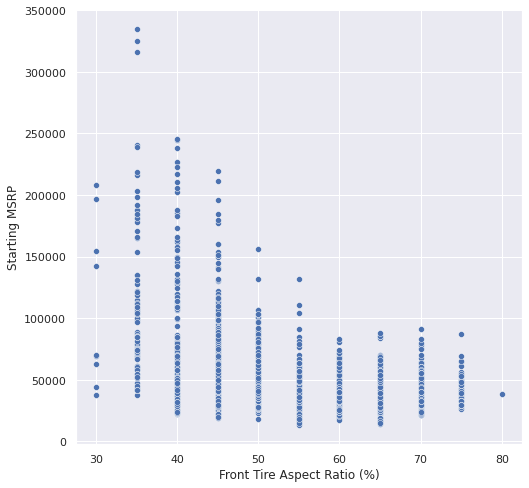

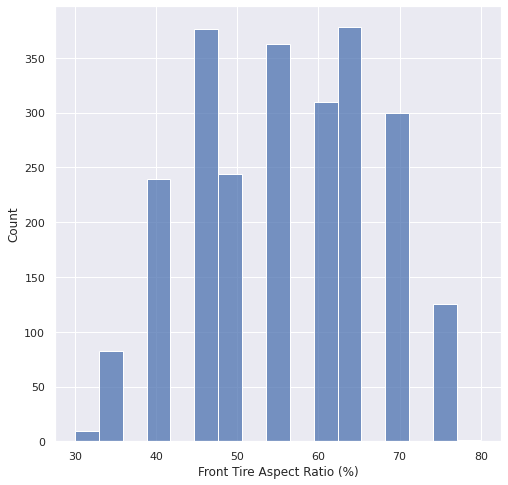

In [ ]:
columnChecker(myCars['Front Tire Aspect Ratio (%)'],myCars["Starting MSRP"])

count    2427.000000
mean       55.356407
std        11.730287
min        30.000000
25%        45.000000
50%        55.000000
75%        65.000000
max        80.000000
Name: Rear Tire Aspect Ratio (%), dtype: float64


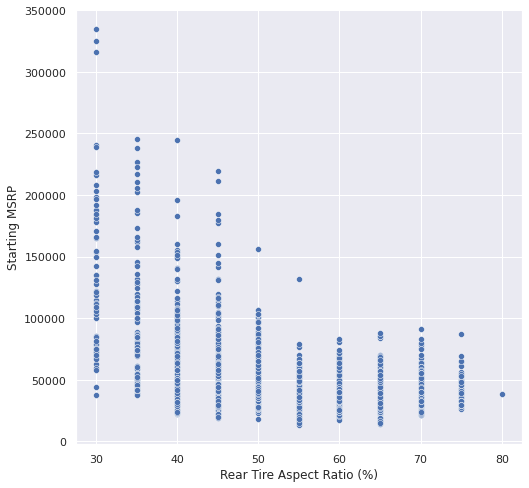

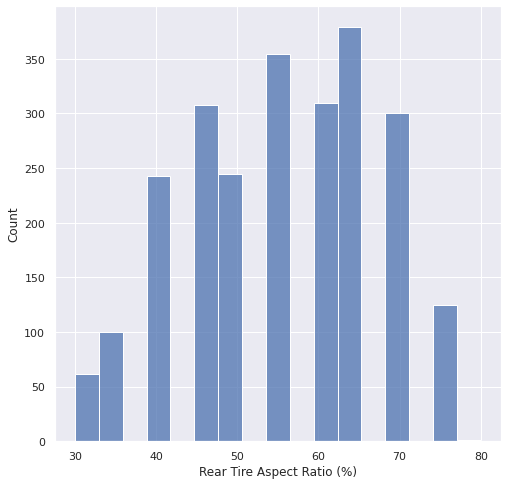

In [ ]:
columnChecker(myCars['Rear Tire Aspect Ratio (%)'],myCars["Starting MSRP"])

count    2427.000000
mean      112.951188
std        15.326170
min        50.900000
25%       102.200000
50%       117.522761
75%       117.522761
max       167.100000
Name: Passenger Volume (ft^3), dtype: float64


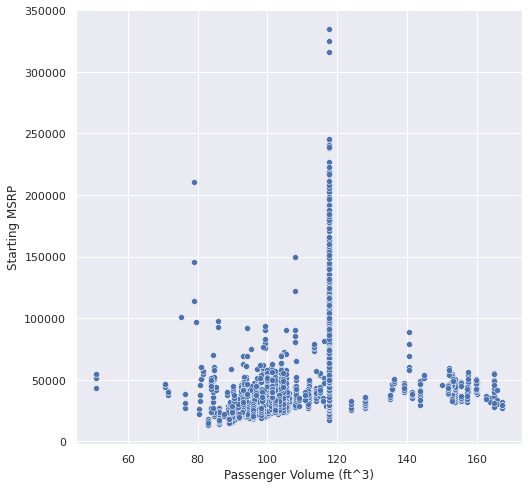

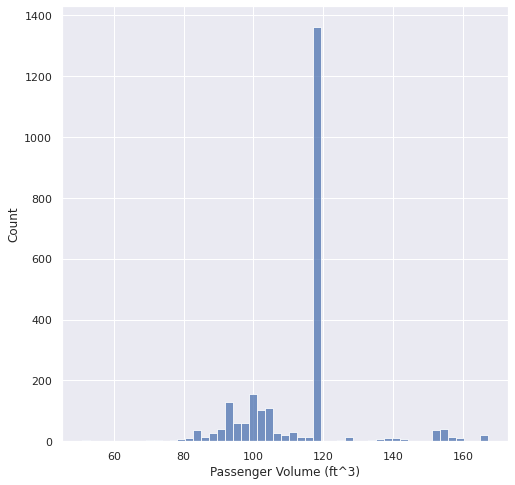

In [ ]:
columnChecker(myCars['Passenger Volume (ft^3)'],myCars["Starting MSRP"])


In [ ]:
drop

Make  Model  ...  front outboard passenger  head-curtain
0     34.0    0.0  ...                       0.0           0.0
1     34.0    0.0  ...                       0.0           0.0
2     34.0    0.0  ...                       0.0           0.0
3     34.0    0.0  ...                       0.0           0.0
4     34.0    0.0  ...                       0.0           0.0
...    ...    ...  ...                       ...           ...
2422  13.0  386.0  ...                       1.0           1.0
2423  13.0  386.0  ...                       1.0           1.0
2424  13.0  386.0  ...                       1.0           1.0
2425   4.0  387.0  ...                       0.0           0.0
2426   4.0  387.0  ...                       0.0           0.0

[2427 rows x 521 columns]

## Establishing Baseline

To establish our baseline we looked for the highest correlating columns with msrp, and then we made regression models with those columns and evaluated their effectivness. The column that was the most predictive "Horse Power" became our baseline and had a r^2 score of 58% on the validation split, & Mean Squared Error of 18,074.

In [ ]:
gCorr = []
for column in xtrain.columns:
    reg = LinearRegression().fit(xtrain[[column]], y_trainScaled)
    x = reg.score(xtrain[[column]], y_trainScaled)
    y = mean_squared_error(y_trainScaled, reg.predict(xtrain[[column]]), squared=False)
    if (drop[drop.columns[column]].corr(msrp) > .70):
      gCorr.append(column)
    if (drop[drop.columns[column]].corr(msrp) < -.70):
      gCorr.append(column)

print(gCorr)

[51, 56]


In [ ]:
#calculates baselines based off category with best solo fit (previous cell)
#column 60 was for horsepower

print(drop.columns[51])
reg = LinearRegression().fit(xtrain[[51]], y_trainScaled)
print("Training Data: ")
eval(reg, xtrain[[51]], y_trainScaled)
print("\nValidation Data: ")
eval(reg, xval[[51]], y_valScaled)
print("\n")

print(drop.columns[56])
reg = LinearRegression().fit(xtrain[[56]], y_trainScaled)
print("Training Data: ")
eval(reg, xtrain[[56]], y_trainScaled)
print("\nValidation Data: ")
eval(reg, xval[[56]], y_valScaled)
print("\n")

Rear Wheel Width (in)
Training Data: 
R2 score: 0.51359625648866
Mean Squared Error: 22802.505096164776

Validation Data: 
R2 score: 0.5170792523526626
Mean Squared Error: 19432.719760157215


Horsepower
Training Data: 
R2 score: 0.5435246245511061
Mean Squared Error: 22089.85089074623

Validation Data: 
R2 score: 0.5822128611898933
Mean Squared Error: 18074.787029874955




In [ ]:
#msrp average, not a good baseline
mean= np.ones(y_trainScaled.shape)
for i in range(0, len(mean)-1):
  mean[i] = msrp.mean()
print(str(msrp.mean())+" msrp Mean")
reg = LinearRegression().fit(mean.reshape(-1,1), y_trainScaled)
print("Training Data: ")
eval(reg, mean.reshape(-1,1), y_trainScaled)
print("\nValidation Data: ")

50097.40914709518 msrp Mean
Training Data: 
R2 score: 5.152899909999231e-05
Mean Squared Error: 32694.36580112969

Validation Data: 


# Model Testing

## Base Model

In [ ]:
#drops one column, runs through every iteration, takes forever

# for column in x_trainScaled.columns:
#     print(column)
#     score(x_trainScaled.drop(columns= column), y_trainScaled)
#     print()

Before we did anything fancy we wanted to get a look at how good a regular linear regression model would do using all of our data, and how it would do on the slim version of our data for predicting msrp.

In [ ]:
#basic linear regression, no tuning or hyperparameters.  Results shown for training and validation data
reg = LinearRegression().fit(x_trainScaled, y_trainScaled)
print("Full Data Training Data: ")
eval(reg, x_trainScaled, y_trainScaled)
print("\nFull Data Validation Data: ")
eval(reg, x_valScaled, y_valScaled)
print("\n")

reg = LinearRegression().fit(x_trainSlim, y_trainSlim)
print("Slim Data Training Data: ")
eval(reg, x_trainSlim, y_trainSlim)
print("\nSlim Data Validation Data: ")
eval(reg, x_valSlim, y_valSlim)
print("\n")

Full Data Training Data: 
R2 score: 0.9645992349172103
Mean Squared Error: 6151.633186089971

Full Data Validation Data: 
R2 score: 0.887036750180049
Mean Squared Error: 9398.623328411863


Slim Data Training Data: 
R2 score: 0.8441006986029925
Mean Squared Error: 12909.40398088276

Slim Data Validation Data: 
R2 score: 0.8469475815311748
Mean Squared Error: 10939.96049775218




## PCA

We noticed that the model was overfitting so we did some experimenting with pca to see if that would fix the problem, and give us a better model. We found that the fit did not get better after using pca to reduce features to 300, and testing on the validation was worse.

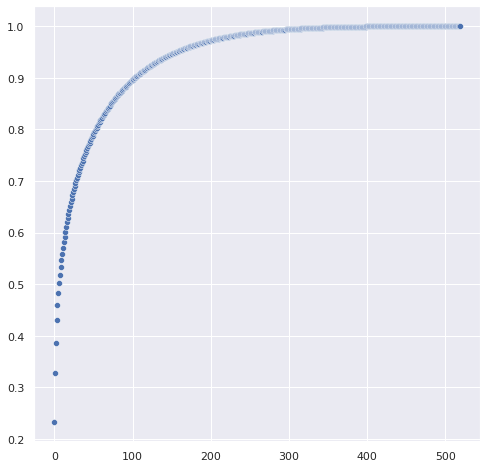

In [ ]:
pca=PCA(n_components=len(xtrain.columns)-1)#was 700
pca.fit(xtrain)
#print(pca.components_[0])
sns.scatterplot(x=range(len(xtrain.columns)-1),y=np.cumsum(pca.explained_variance_ratio_))#was 700


In [ ]:
pca=PCA(n_components=100)
pca.fit(x_trainScaled)
x_train = pca.transform(x_trainScaled)
x_val = pca.transform(x_valScaled)
reg = LinearRegression().fit(x_train, y_trainScaled)
print("Pca Scaled Data Training Data: ")
eval(reg, x_train, y_trainScaled)
print("\nPca Scaled Data Validation Data: ")
eval(reg, x_val, y_valScaled)
print("\n")

reg = LinearRegression().fit(x_trainScaled, y_trainScaled)
print("Scaled Data Training Data: ")
eval(reg, x_trainScaled, y_trainScaled)
print("\nScaled Data Validation Data: ")
eval(reg, x_valScaled, y_valScaled)
print("\n")

Pca Scaled Data Training Data: 
R2 score: 0.8544277167361641
Mean Squared Error: 12474.508808469522

Pca Scaled Data Validation Data: 
R2 score: 0.8433365365238061
Mean Squared Error: 11068.264203782752


Scaled Data Training Data: 
R2 score: 0.9645992349172103
Mean Squared Error: 6151.633186089971

Scaled Data Validation Data: 
R2 score: 0.887036750180049
Mean Squared Error: 9398.623328411863




## RidgeCV

Here we tried using a RidgeCV model instead of the linear Regression model and found it to be a signifigantly better than the linear regression model. It performed the best on the full data set, and worse on the pca reduced data set & slimmed data set.

In [ ]:
reg = RidgeCV().fit(x_trainScaled,y_trainScaled)
print("Full Data Training Data: ")
eval(reg, x_trainScaled, y_trainScaled)
print("\nFull Data Validation Data: ")
eval(reg, x_valScaled, y_valScaled)
print("\n")

reg = RidgeCV().fit(x_trainSlim,y_trainSlim)
print("Slim Data Training Data: ")
eval(reg, x_trainSlim, y_trainSlim)
print("\nSlim Data Validation Data: ")
eval(reg, x_valSlim, y_valSlim)
print("\n")

reg = RidgeCV().fit(x_train,y_trainScaled)
print("Pca of Full Data, Training Data: ")
eval(reg, x_train, y_trainScaled)
print("\nPca of Full Data, Validation Data: ")
eval(reg, x_val, y_valScaled)
print("\n")

Full Data Training Data: 
R2 score: 0.957711390160115
Mean Squared Error: 6723.506227460543

Full Data Validation Data: 
R2 score: 0.8958260165123821
Mean Squared Error: 9025.583558910985


Slim Data Training Data: 
R2 score: 0.8422206722353265
Mean Squared Error: 12987.009486725849

Slim Data Validation Data: 
R2 score: 0.8464714789530987
Mean Squared Error: 10956.962839702715


Pca of Full Data, Training Data: 
R2 score: 0.8544249161322204
Mean Squared Error: 12474.628803807069

Pca of Full Data, Validation Data: 
R2 score: 0.8435536753834196
Mean Squared Error: 11060.591120458455




## Poly Fit

Here we experimented with the polynomial features and RidgeCV to see if poly fitting our data would get better results with RidgeCV. It was better then our wildest expectations and scored an impressive R2 score of 98%, and Mean Squared error of 4221.

In [ ]:
poly = PolynomialFeatures(2)
bomb = poly.fit_transform(numberCat)

In [ ]:
x_test,y_test,x_train,y_train,x_val, y_val=splits(bomb,.8,.2)
reg = RidgeCV().fit(x_train,y_train)
print("Training Data: ")
eval(reg, x_train, y_train)
print("\nValidation Data: ")
eval(reg, x_val, y_val)
print("\n")
print("Test Data: ")
eval(reg, x_test, y_test)

Splits: test=0.2 train=0.6400000000000001 val=0.16000000000000003
Training Data: 
R2 score: 0.9999906400464561
Mean Squared Error: 100.02785449675916

Validation Data: 
R2 score: 0.9772057261972862
Mean Squared Error: 4221.905769874514


Test Data: 
R2 score: 0.9524445773056551
Mean Squared Error: 6026.745165408025


The cell below graphs a histogram of the residuals from our model for the validation data, and shows that most of the residuals are fairly close to the prediction.

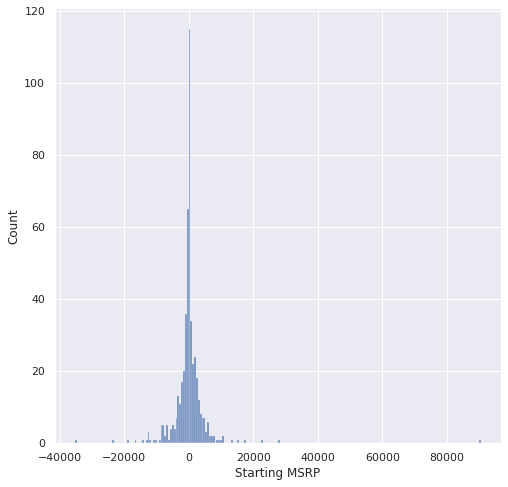

In [ ]:
sns.set(rc = {'figure.figsize':(8,8)})
sns.histplot(x=y_test - reg.predict(x_test))
plt.show()

We graphed The homestacity of our model below, and we can see that that the model becomes less accurate for more expsensive models. This is not too surprising since the more exspensive luxury cars are a lot more rare, and so our data is heavily concentrated on cheaper models around the $50,000 mark.

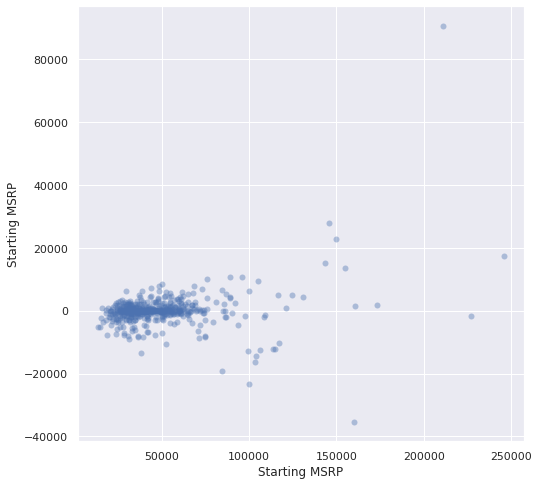

In [ ]:
sns.scatterplot( x=y_test,y=y_test - reg.predict(x_test),alpha=.4,linewidth=0)
plt.show()


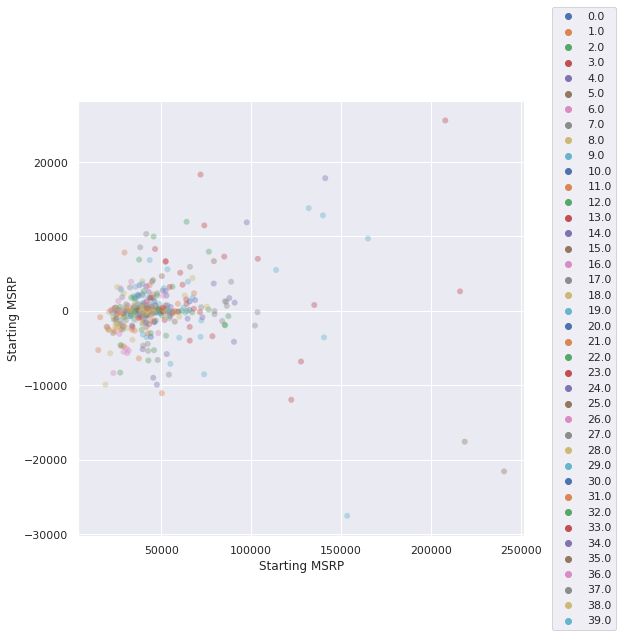

In [ ]:
sns.scatterplot( x=y_val,y=y_val - reg.predict(x_val),alpha=.4,linewidth=0,hue=original["Make"], palette="deep")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.show()

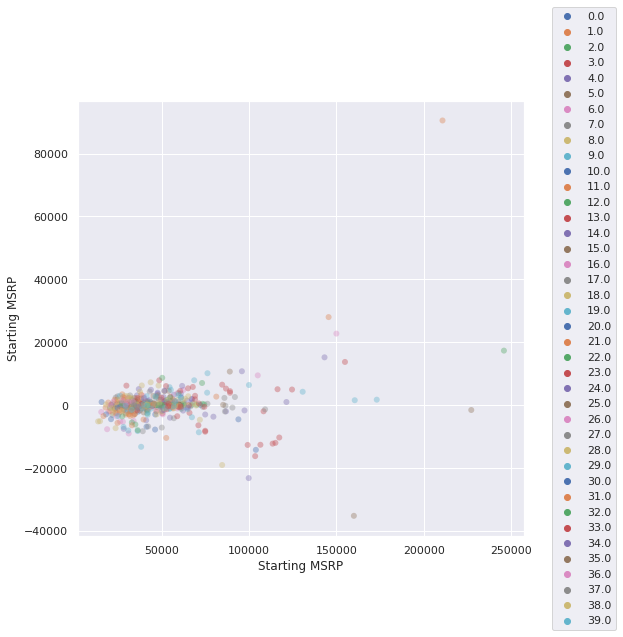

In [ ]:
sns.scatterplot( x=y_test,y=y_test - reg.predict(x_test),alpha=.4,linewidth=0,hue=original["Make"], palette="deep")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.show()

In [ ]:
labels = poly.get_feature_names_out(numberCat.columns)

tempBomb = pd.DataFrame(bomb)

explode = tempBomb.set_axis([labels], axis=1)

## Unit Analysis

Here we broke our train and val data into sub-groups based on vehicle type and make and ran them through our regression model to see how they scored.  The results: not bad.

In [ ]:
carMakes = explode["Make"].value_counts().index

In [ ]:
carTypes = explode["Vehicle Type"].value_counts().index

In [ ]:
#takes 7 arguments: (1) a pre-trained regression, (2) a list of categories (as a tuple (cat,), because thats how we had them), 
#(3) a column index (where to find the category's column in our np arrays), (4-7) training and validation splits
#(we implemented this function using the same splits as for our previous runs of the entire model)

def splitCat(reg,catList,colIndex,x_train,y_train,x_val,y_val):
  
  regScores=[]
  countScores=[]

  for k in range(len(catList)):  #iterates through each category value
    trainRowsX=[]
    trainRowsY=[]
    valRowsX=[]
    valRowsY=[]
    cat=catList[k][0] #pulls category value from the tuple

    for i in range(len(x_train)):   #iterates through every row in training data
      if x_train[i][colIndex]==cat:            #if the column contains the right category value
        trainRowsX.append(x_train[i])              #append full row to trainRowsX
        trainRowsY.append(y_train.values[i])       #append label entry to trainRowsY
    for i in range(len(x_val)):     #same, but iterates through rows in val data
      if x_val[i][colIndex]==cat:
        valRowsX.append(x_val[i])
        valRowsY.append(y_val.values[i])

    trainCount=(Counter(x_train[:,colIndex])[cat]) #checks how instances of that category value were in the training data
    valCount=(Counter(x_val[:,colIndex])[cat])   #' ' in the val data

    if ((trainCount>1) and (valCount>1)):     #if there were at least two of each (enough to do regression with)
      avg=((reg.score(trainRowsX,trainRowsY))+(reg.score(valRowsX,valRowsY)))/2   #average regression scores
      sum=trainCount+valCount        #sum the counts
      regScores.append(avg)          #add average reg score and total counts to their lists
      countScores.append(sum)
    elif((trainCount>1)):   #if there's not enough val data to do regression with
      regScores.append(reg.score(trainRowsX,trainRowsY))   #just calculate scores and counts with train data
      countScores.append(trainCount)
    elif((valCount>1)):    #if there's not enough train data to do regression with
      regScores.append(reg.score(valRowsX,valRowsY))   #just calculate scores and counts with val data
      countScores.append(valCount)
    else:                  #if theres not enough of either
      regScores.append(0)         #just put zeros
      countScores.append(0)

  return regScores, countScores   #return the regression scores and count scores


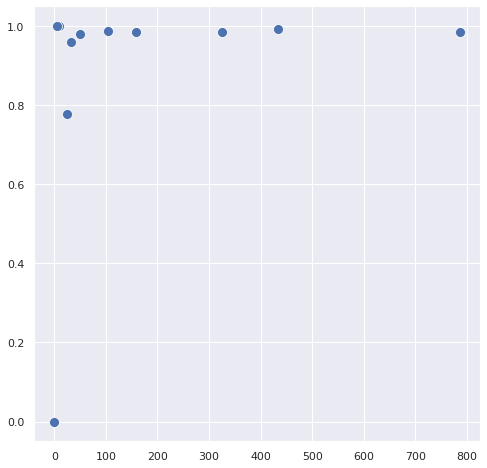

In [ ]:
#labels[3]  #column 3 for Vehicle Type
typesReg, typesCount = splitCat(reg,carTypes,3,x_train,y_train,x_val,y_val)
sns.scatterplot(x=typesCount,y=typesReg, s=100)

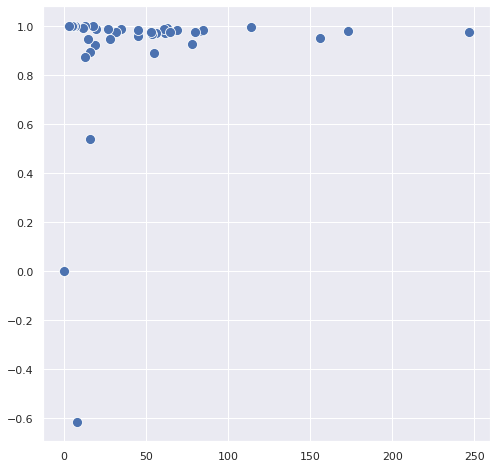

In [ ]:
#labels[1]     #column 1 for Make
makesReg, makesCount = splitCat(reg,carMakes,1,x_train,y_train,x_val,y_val)
sns.scatterplot(x=makesCount, y=makesReg,s=100)